In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('Case Study - Raw Data Google Data.xlsx')
df.head()

,_id,detail_url,shop_name,phone,price_range,category,score,address,locatedin
0,686a78a8f8e3455e3cbca676,https://www.google.com/maps/place/Ippondo+Japa...,Ippondo Japanese & Korean Cosmemart 630 George...,NaN,NaN,Cosmetics store,4.9 stars,"630 George St, Sydney NSW 2000, Australia",NaN
1,6874793f138006c93a218fdb,https://www.google.com/maps/place/Hair+by+Jaam...,Hair by Jaamie,NaN,NaN,Beauty salon,5.0 stars,"307 Nelson Rd, Nelson NSW 2765, Australia",NaN
2,6874793f138006c93a218fda,https://www.google.com/maps/place/Illuminate+b...,Illuminate body,NaN,NaN,Beauty salon,5.0 stars,"Cinema Mall, Shop 19/23 Stockton St, Nelson Ba...",NaN
3,6874793f138006c93a218fd4,https://www.google.com/maps/place/Tame+Studio/...,Tame Studio,NaN,NaN,Beauty salon,5.0 stars,"2-4 Yacaaba St, Nelson Bay NSW 2315, Australia",NaN
4,6874793db2350cfa2c0ab076,https://www.google.com/maps/place/Elegance+Bro...,Elegance Brows,NaN,NaN,Beauty salon,3.5 stars,"Maroubra NSW 2035, Australia",Floor G · Pacific Square


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238778 entries, 0 to 238777
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   _id          238778 non-null  object
 1   detail_url   238778 non-null  object
 2   shop_name    238778 non-null  object
 3   phone        197534 non-null  object
 4   price_range  25314 non-null   object
 5   category     231290 non-null  object
 6   score        179743 non-null  object
 7   address      238778 non-null  object
 8   locatedin    37014 non-null   object
dtypes: object(9)
memory usage: 16.4+ MB


In [ ]:
df.describe()

,_id,detail_url,shop_name,phone,price_range,category,score,address,locatedin
count,238778,238778,238778,197534,25314,231290,179743,238778,37014
unique,238778,238778,225008,170224,36,3233,44,178534,10273
top,6874f2edf42cf5e9b5167b0a,https://www.google.com/maps/place/%D9%85%D9%88...,The Lott,+61 131406,A$1–20,Bus stop,5.0 stars,"Sydney NSW 2000, Australia",Floor 0 · Rouse Hill Town Centre
freq,1,1,292,262,8442,5337,60188,270,206


In [ ]:
# Wrong scrapping column in price range instead of category
df['category'] = df['category'].fillna(df['price_range'])

# Remove price_range not starting with A$
df.loc[~df['price_range'].str.startswith('A$', na=False), 'price_range'] = pd.NA

In [ ]:
print('Score missing percent:', round(df['score'].isna().sum()/df.shape[0]*100,2))
print('Category missing percent', round(df['category'].isna().sum()/df.shape[0]*100,2))

Score missing percent: 24.72
Category missing percent 0.67


In [ ]:
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Get category counts sorted descending
counts = df['category'].value_counts()

# Compute the cumulative percentage
cum_pct = counts.cumsum() / counts.sum()

# Keep only categories that fall within the top 80% of occurrences
top_80 = counts[cum_pct <= 0.8].index

top_80

Index(['bus stop', 'corporate office', 'cafe', 'construction company',
       'beauty salon', 'real estate agency', 'restaurant', 'apartment',
       'clothing store', 'day care center',
       ...
       'office supply store', 'furniture manufacturer', 'public library',
       'building consultant', 'coffee roasters',
       'construction equipment supplier', 'bottle & can recycling centre',
       'volunteer organization', 'ferry terminal', 'hotel'],
      dtype='object', name='category', length=434)

In [ ]:
# Remove rows missing category or scores to profile
df = df.dropna(subset=['category','score'])

# List of categories to remove
exclude = ['bus stop', 'corporate office', 'real estate agency']

# Keep only rows where 'category' is NOT in the exclude list
df = df[~df['category'].isin(exclude)]


# Classify category to KPay industry
def classify_category(cat):
    if any(k in cat for k in ['salon', 'barber','spa', 'fitness','wellness', 'gym', 'education','clinic', 'repair', 'consult', 'service','barber','clean', 'photography', 'pet']):
        return 'Services'
    elif any(k in cat for k in ['restaurant', 'bar', 'cafe', 'lounge','night club','hotel', 'apartment', 'accomodation', 'bistro', 'tea', 'caterer', 'ice cream','steak house']):
        return 'Hospitality'
    elif any(k in cat for k in ['store', 'shop', 'market', 'retail', 'cloth']):
        return 'Retail'
    else:
        return 'General Industry'

df['industry_group'] = df['category'].apply(classify_category)

# Convert score to numeric value
df['score'] = pd.to_numeric(df['score'].str.extract(r'([\d.]+)')[0], errors='coerce')

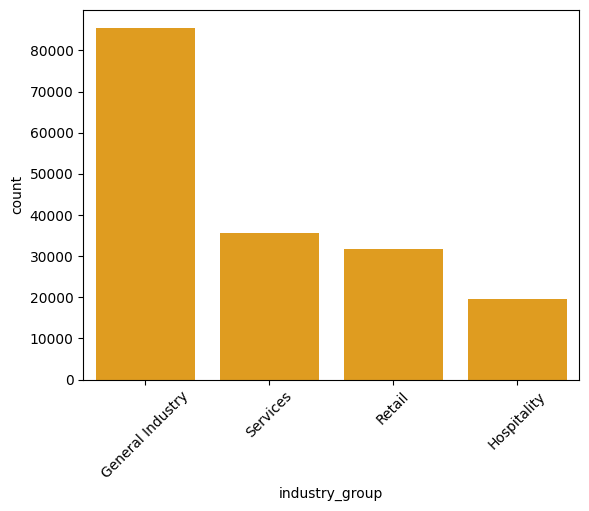

In [ ]:
# Get counts of each industry group
industry_counts = df['industry_group'].value_counts().reset_index()
industry_counts.columns = ['industry_group', 'count']

# Plot
sns.barplot(data=industry_counts, x='industry_group', y='count', color='orange')
plt.xticks(rotation=45)  # rotate labels if needed
plt.show()

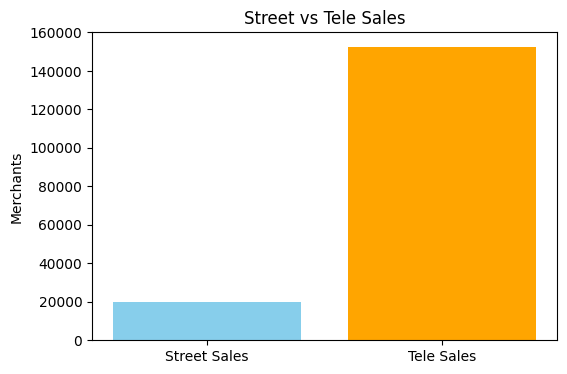

In [ ]:
street_sales = df['phone'].isna().sum()
tele_sales = df.shape[0] - street_sales

# Prepare data
categories = ['Street Sales', 'Tele Sales']
counts = [street_sales, tele_sales]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(categories, counts, color=['skyblue', 'orange'])
plt.title('Street vs Tele Sales')
plt.ylabel('Merchants')
plt.show()

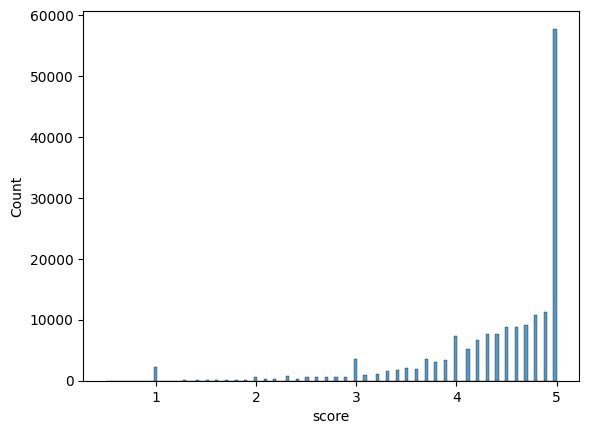

In [ ]:
sns.histplot(data = df, x='score')
plt.show()

In [ ]:
# Define scores for new business
new_scores = [1.0, 2.0, 3.0, 4.0, 5.0]

# Create new_business and stable_business DataFrames
new_business = df[df['score'].isin(new_scores)]
stable_business = df[~df['score'].isin(new_scores)]

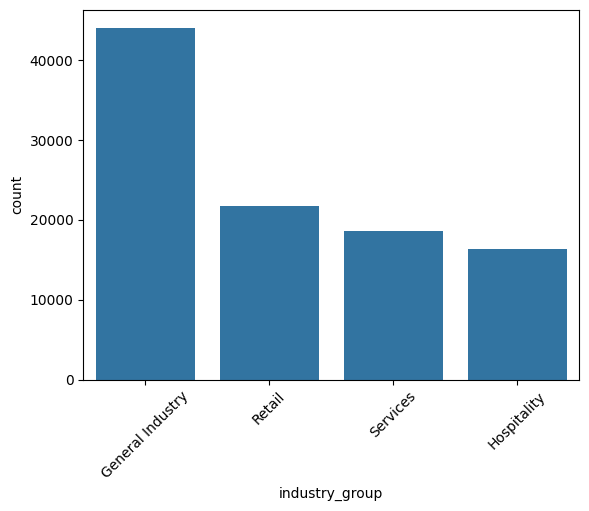

In [ ]:
# Get counts of each industry group
industry_counts = stable_business['industry_group'].value_counts().reset_index()
industry_counts.columns = ['industry_group', 'count']

# Plot
sns.barplot(data=industry_counts, x='industry_group', y='count')
plt.xticks(rotation=45)  # rotate labels if needed
plt.show()

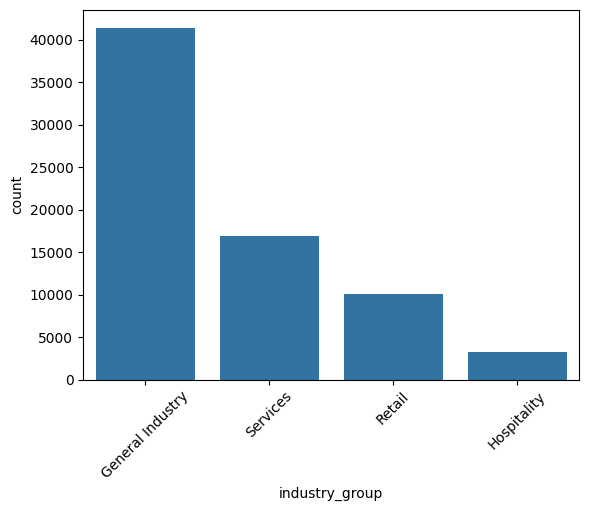

In [ ]:
# Get counts of each industry group
industry_counts = new_business['industry_group'].value_counts().reset_index()
industry_counts.columns = ['industry_group', 'count']

# Plot
sns.barplot(data=industry_counts, x='industry_group', y='count')
plt.xticks(rotation=45)  # rotate labels if needed
plt.show()

In [ ]:
# Filter to the three target industries
stable_subset = stable_business[stable_business['industry_group'].isin(['Services', 'Retail', 'Hospitality'])]

# Compute proportional sample sizes
total_sample = 1500
counts = stable_subset['industry_group'].value_counts()
proportions = counts / counts.sum()
sample_sizes = (proportions * total_sample).round().astype(int)  # round to nearest int

# Stratified sampling
sampled = stable_subset.groupby('industry_group', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), sample_sizes[x.name]), random_state=42)
).reset_index()

# Check distribution
print(sampled['industry_group'].value_counts())

industry_group
Retail         575
Services       493
Hospitality    432
Name: count, dtype: int64


/tmp/ipython-input-58265968.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = stable_subset.groupby('industry_group', group_keys=False).apply(


In [ ]:
scrap = pd.read_csv("1013000.csv")
reviews = scrap[
    scrap['number_of_reviews'].notnull() &
    (scrap['number_of_reviews'].astype(str).str.len() < 14)
]['number_of_reviews']
reviews = (reviews
  .str.extract(r'(\d[\d,]*)')[0]        # extract numeric part (handles commas)
    .str.replace(',', '', regex=False)    # remove commas
    .astype(float)                        # convert to number
)


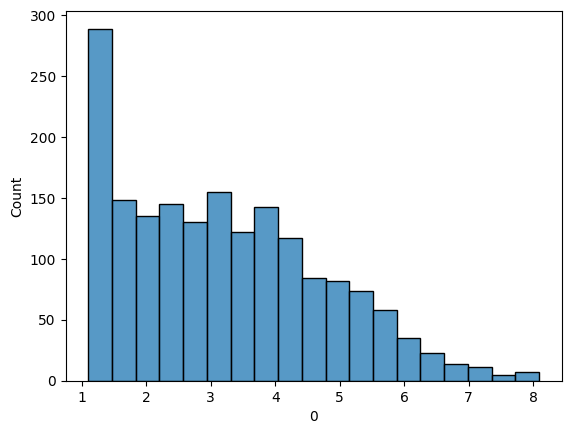

In [ ]:
sns.histplot(np.log1p(reviews))
plt.show()

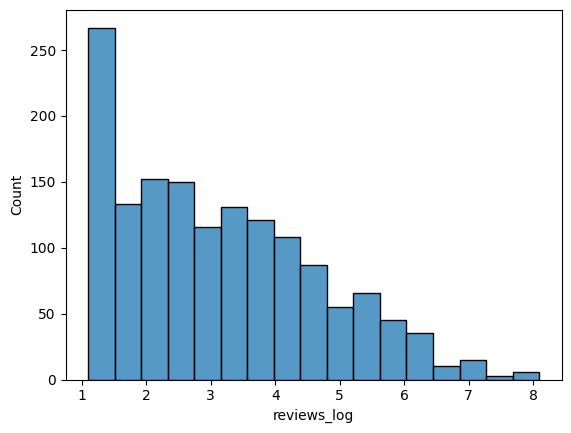

In [ ]:
# Compute log of reviews for the full dataset
reviews_log = np.log1p(reviews)
sampled['reviews_log'] = np.random.choice(reviews_log, size=len(sampled), replace=True)
sns.histplot(data=sampled, x='reviews_log')
plt.show()

In [ ]:
# Generate digital presence
sampled['digital_presence'] = np.random.choice([0, 1], size = total_sample, p=[0.6, 0.4])

# Generate 500 random dates within the last 30 days
today = pd.Timestamp.today().normalize()
random_dates = today - pd.to_timedelta(np.random.randint(0, 30, size=500), unit='D')

# Assign to the first 500 rows
sampled.loc[:499, 'contact_date'] = random_dates

# Define probabilities
categories = ['won', 'lost', 'process']
probs = [0.25, 0.35, 0.40]

# Randomly assign to first 500 rows
sampled.loc[:499, 'process_status'] = np.random.choice(categories, size=500, p=probs)

# Merchant rating
sampled['reviews_log_norm'] = (
    (sampled['reviews_log'] - sampled['reviews_log'].min()) /
    (sampled['reviews_log'].max() - sampled['reviews_log'].min())
)
sampled['score_norm'] = sampled['score'] / 5
sampled['merchant_rating'] = (
    10 * sampled['digital_presence'] +
    20 * (sampled['score_norm']/5) +
    70 * (sampled['reviews_log_norm'])
)

sampled['tier'] = pd.qcut(sampled['merchant_rating'],
                          q=[0, 0.5, 0.75, 1],
                          labels=['Tier 3', 'Tier 2', 'Tier 1']
                  )
sampled.to_csv('sample.csv')